<a href="https://colab.research.google.com/github/vneumannufprbr/PracticasTensorflow/blob/main/PredicSTLSTMEolEspaOkGit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Procesando variable: generation wind onshore

Entrenando LSTM para evaluación...
Entrenamiento completado.

Métricas de Evaluación en Conjunto de Prueba para 'generation wind onshore':
  R^2: 0.9638
  MSE: 362934.3930
  RMSE: 602.4404
  MAE: 292.9855

Re-entrenando LSTM con datos completos para pronóstico futuro...
Epoch 1/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 38s 132ms/step - loss: 0.0084 - root_mean_squared_error: 0.1213
Epoch 2/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 41s 132ms/step - loss: 0.0014 - root_mean_squared_error: 0.0533
Epoch 3/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 40s 128ms/step - loss: 9.5340e-04 - root_mean_squared_error: 0.0436
Epoch 4/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 36s 132ms/step - loss: 7.8103e-04 - root_mean_squared_error: 0.0395
Epoch 5/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 40s 128ms/step - loss: 7.5197e-04 - root_mean_squared_error: 0.0387
Epoch 6/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 44s 140ms/step - loss: 7.1387e-04 - root_mean_squared_error: 0.0377
Epoch 7/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 39

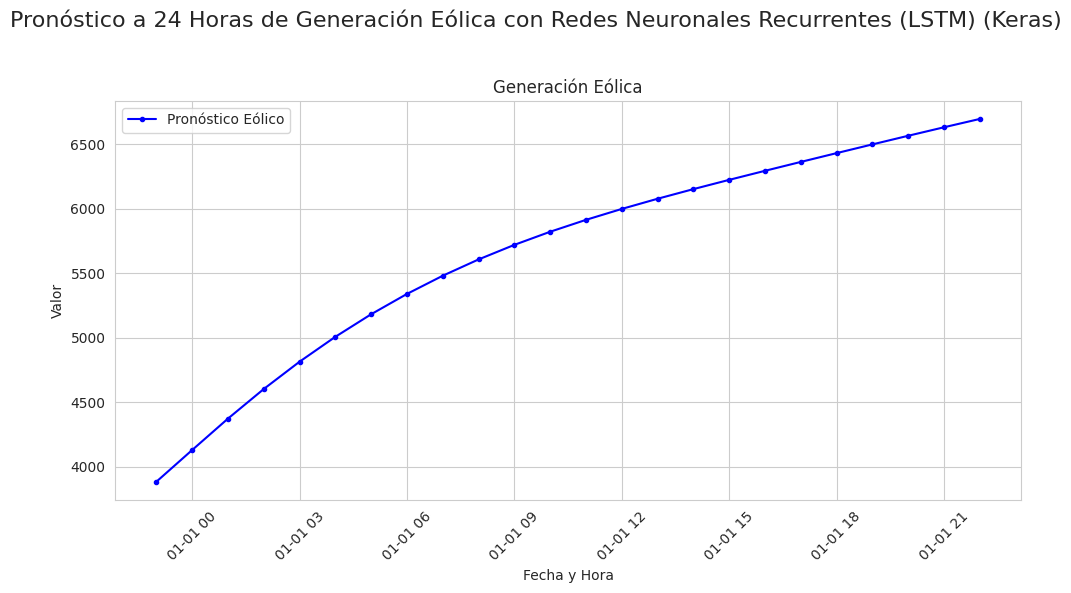

In [24]:
# -*- coding: utf-8 -*-
"""
Regresión de Series Temporales con TensorFlow/Keras.

Este script es para pronosticar serie temporal
de generación de energía (eólica) usando redes neuronales.
"""

# --- 1. INSTALACIÓN Y CARGA DE LIBRERÍAS ---
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, LSTM # Cambiar GRU por LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.losses import Huber
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

import random as python_random

# Importar métricas de Keras
from tensorflow.keras.metrics import RootMeanSquaredError

# Fijar semillas para reproducibilidad
np.random.seed(42)
python_random.seed(42)
tf.random.set_seed(42)

# Configuración de estilo para los gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)

# --- 2. LECTURA Y PREPARACIÓN DE DATOS ---

# Leer y preparar los datos desde la URL
#url = "https://raw.githubusercontent.com/vneumannufprbr/TrabajosRStudio/main/energy_dataset.csv" # Dataset con 3.500 instancias
#data = pd.read_csv(url) # Dataset con 3.500 instancias

url =  "https://raw.githubusercontent.com/vneumannufprbr/Series-Temporales/main/energy_dataset.csv" # Dataset con 35.000 instancias
data = pd.read_csv(url) # Dataset con 35.000 instancias # dtype=dtype_dict,

# Convertir la columna 'time' a formato datetime y ordenar
data['time'] = pd.to_datetime(data['time'], utc=True)
data = data.sort_values('time')

# --- 3. DEFINICIÓN DE PARÁMETROS Y FUNCIONES AUXILIARES ---

# Seleccionar variable objetivo única (Generación Solar)
targets = ["generation wind onshore"] # Cambiar a generación eólica
# Cambiar nombres con puntos por espacios para facilitar el acceso en pandas
data.columns = [col.replace('.', ' ') for col in data.columns]

# Diccionarios para almacenar resultados
results = {}
metrics = {}
histories = {} # Para guardar el historial de entrenamiento

# Parámetros del modelo
WINDOW_SIZE = 48       # Ventana de 24 horas
TEST_SIZE = int(0.1 * len(data))  # 10% del total de instancias, antes de 24
FORECAST_HORIZON = 24  # Horizonte de 24 horas para pronóstico futuro

def create_features(series, window_size):
    """
    Crea un dataset de características (X) y objetivo (y) a partir de una serie temporal.
    """
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:(i + window_size)])
        y.append(series[i + window_size])
    return np.array(X), np.array(y)

def calculate_metrics(actual, predicted):
    """
    Calcula e imprime las métricas de evaluación R2, RMSE, MSE y MAE.
    """
    r2 = r2_score(actual, predicted)
    mse = mean_squared_error(actual, predicted) # Calcular MSE
    rmse = np.sqrt(mse) # RMSE es la raíz cuadrada del MSE
    mae = mean_absolute_error(actual, predicted)

    print(f"  R^2: {r2:.4f}")
    print(f"  MSE: {mse:.4f}") # Imprimir MSE
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")


    return {"R2": r2, "MSE": mse, "RMSE": rmse, "MAE": mae} # Incluir MSE en el diccionario

def plot_loss_evolution(history, target_var):
    """
    Grafica la evolución de la pérdida de entrenamiento y validación.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Pérdida de Entrenamiento') # Translated label
    plt.plot(history.history['val_loss'], label='Pérdida de Validación') # Translated label
    plt.title(f'Evolución de la Función de Pérdida para: {target_var}')
    plt.xlabel('Épocas') # Translated label
    plt.ylabel('Error Cuadrático Medio (MSE)')
    plt.legend()
    plt.show()

# --- 4. ENTRENAMIENTO, EVALUACIÓN Y PRONÓSTICO CON KERAS ---

# Bucle para cada variable objetivo (ahora solo 'generation solar')
for target_var in targets:
    print(f"\n{'='*50}")
    print(f"Procesando variable: {target_var}")
    print(f"{'='*50}")

    # Extraer la serie completa y eliminar valores nulos
    series_full = data[target_var].dropna().to_numpy()

    # 1. DIVISIÓN EN ENTRENAMIENTO Y PRUEBA
    train_series = series_full[:-TEST_SIZE]
    test_series_actual = series_full[-TEST_SIZE:]

    # Crear características para el conjunto de entrenamiento
    X_train, y_train = create_features(train_series, WINDOW_SIZE)
    y_train = y_train.reshape(-1, 1) # Asegurar que y_train tenga 2 dimensiones

    # Escalar datos de entrenamiento a [0, 1]
    # Se usa un scaler para las características (X) y otro para el objetivo (y)
    scaler_X = MinMaxScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)

    scaler_y = MinMaxScaler()
    y_train_scaled = scaler_y.fit_transform(y_train)

    # Las LSTMs esperan una entrada 3D (muestras, pasos de tiempo, características)
    X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))


    # 2. CONSTRUCCIÓN Y ENTRENAMIENTO DEL MODELO DE EVALUACIÓN
    print("\nEntrenando LSTM para evaluación...")

    model_eval = Sequential([
        Input(shape=(WINDOW_SIZE, 1)),  # Capa de entrada para LSTM
        LSTM(160, activation='relu'), # Capa LSTM con 128 unidades
        #Dense(32, activation='relu'), # Segunda capa oculta
        #Dense(16, activation='relu'), # Tercera capa oculta
        Dense(1)                      # Capa de salida lineal
    ])

    model_eval.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='huber', metrics =[RootMeanSquaredError()]) #loss='mean_squared_error, y sin metrics

    # Entrenar el modelo y guardar el historial para graficar la pérdida
    history = model_eval.fit(
        X_train_scaled,
        y_train_scaled,
        epochs=10, # epochs=50
        validation_split=0.2, # Usa el 20% de los datos para validación
        batch_size=128, # 32
        verbose=0 # 0 para no mostrar el log de cada época
    )


    histories[target_var] = history
    print("Entrenamiento completado.")

    # 3. PREDICCIÓN RECURSIVA EN EL CONJUNTO DE PRUEBA
    test_predictions = []
    # Use the actual test series for the recursive prediction loop for evaluation
    current_window = train_series[-WINDOW_SIZE:].tolist()

    for i in range(TEST_SIZE):
        # Escalar la ventana actual y darle la forma 3D
        window_scaled = scaler_X.transform(np.array(current_window).reshape(1, -1))
        window_scaled = window_scaled.reshape((window_scaled.shape[0], window_scaled.shape[1], 1))


        # Predecir el siguiente valor
        pred_scaled = model_eval.predict(window_scaled, verbose=0)

        # Des-escalar la predicción
        pred_actual = scaler_y.inverse_transform(pred_scaled)[0, 0]

        # Guardar la prediction
        test_predictions.append(pred_actual)

        # Update the window using the actual value from the test set
        current_window.pop(0)
        current_window.append(test_series_actual[i])


    # Calcular y mostrar métricas de evaluación
    print(f"\nMétricas de Evaluación en Conjunto de Prueba para '{target_var}':")
    metrics[target_var] = calculate_metrics(test_series_actual, test_predictions)

    # 4. PRONÓSTICO FUTURO USANDO TODO EL DATASET
    print("\nRe-entrenando LSTM con datos completos para pronóstico futuro...")

    # Preparar datos completos
    X_full, y_full = create_features(series_full, WINDOW_SIZE)
    y_full = y_full.reshape(-1, 1)

    scaler_X_full = MinMaxScaler()
    X_full_scaled = scaler_X_full.fit_transform(X_full)

    scaler_y_full = MinMaxScaler()
    y_full_scaled = scaler_y_full.fit_transform(y_full)

    # Dar forma 3D a los datos completos para la LSTM
    X_full_scaled = X_full_scaled.reshape((X_full_scaled.shape[0], X_full_scaled.shape[1], 1))


    # Construir y entrenar el modelo final
    model_final = Sequential([
        Input(shape=(WINDOW_SIZE, 1)), # Capa de entrada para LSTM
        LSTM(160, activation='relu'), # Capa LSTM con 128 unidades
        #Dense(32, activation='relu'), # Segunda capa oculta
        #Dense(16, activation='relu'), # Tercera capa oculta
        Dense(1)                      # Capa de salida lineal
    ])
    model_final.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='huber', metrics =[RootMeanSquaredError()]) #loss='mean_squared_error, y sin metrics
    model_final.fit(X_full_scaled, y_full_scaled, epochs=10, batch_size=128, verbose=1) #epochs=50, batch_size=32

    print("Entrenamiento completado.")

    # Generar pronóstico futuro
    future_predictions = []
    last_window_full = series_full[-WINDOW_SIZE:].tolist()

    # Determine a reasonable clipping range for future predictions based on full dataset
    min_val_full = series_full.min()
    max_val_full = series_full.max()
    clip_range_full = (min_val_full, max_val_full) # Or a slightly wider range

    for _ in range(FORECAST_HORIZON):
        # Escalar la última ventana completa y darle forma 3D
        window_scaled = scaler_X_full.transform(np.array(last_window_full).reshape(1, -1))
        window_scaled = window_scaled.reshape((window_scaled.shape[0], window_scaled.shape[1], 1))

        pred_scaled = model_final.predict(window_scaled, verbose=0)
        pred_actual = scaler_y_full.inverse_transform(pred_scaled)[0, 0]

        # Clip the future prediction to a reasonable range
        pred_actual_clipped = np.clip(pred_actual, clip_range_full[0], clip_range_full[1])


        future_predictions.append(pred_actual_clipped)
        last_window_full.pop(0)
        last_window_full.append(pred_actual_clipped)

    results[target_var] = future_predictions

# --- 5. VISUALIZACIÓN DE RESULTADOS ---

# Crear DataFrame con los pronósticos para 'generation wind'
last_date = data['time'].iloc[-1]
future_dates = pd.to_datetime([last_date + pd.DateOffset(hours=i) for i in range(1, FORECAST_HORIZON + 1)])

forecast_df = pd.DataFrame({
    'time': future_dates,
    'wind': results['generation wind onshore'] # Cambiar a 'wind'
})

# Graficar los pronósticos (solo para Generación Solar)
plt.figure(figsize=(10, 6)) # Ajustar tamaño de la figura
plt.suptitle('Pronóstico a 24 Horas de Generación Eólica con Redes Neuronales Recurrentes (LSTM) (Keras)', fontsize=16, y=0.98) # Actualizar título y posición

# Gráfico para Generación Eólica
plt.plot(forecast_df['time'], forecast_df['wind'], label='Pronóstico Eólico', color='blue', marker='.') # Cambiar label y color
plt.title('Generación Eólica') # Cambiar título
plt.xlabel('Fecha y Hora') # Añadir etiqueta al eje X
plt.ylabel('Valor')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True) # Añadir cuadrícula

plt.tight_layout(rect=[0, 0, 1, 0.95]) # Ajustar layout para el título
plt.show()